In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing import image
from keras.regularizers import l2
from keras.layers import Dropout, Input, Conv2D, DepthwiseConv2D, Dense, GlobalAveragePooling2D
from keras.layers import BatchNormalization, ReLU, Multiply, Reshape, Add
from keras.models import Model
from keras.initializers import he_normal
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.callbacks import LearningRateScheduler
import numpy as np
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [2]:
#Importing Data
train_dir=r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Dataset\Train'
test_dir=r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Dataset\Test'
valid_dir=r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Dataset\Valid'

In [3]:
#Rescaling and augmentation of data
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224,224,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
],name="data_augmentation")


In [4]:
IMG_SIZE=(224,224)
BATCH_SIZE=5
training_set=tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode = 'categorical',
    shuffle=False
)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory = valid_dir,
    image_size = IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode = 'categorical',
)
class_names=validation_set.class_names

Found 1376 files belonging to 5 classes.
Found 172 files belonging to 5 classes.
Found 172 files belonging to 5 classes.


In [5]:
# Add Rescaling outside the data_augmentation
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

training_set = training_set.map(lambda x, y: (rescale(x), y))
test_set = test_set.map(lambda x, y: (rescale(x), y))
validation_set = validation_set.map(lambda x, y: (rescale(x), y))

In [6]:
def swish(x):
    return x * tf.keras.activations.sigmoid(x)

def SEBlock(input_x, filters, se_ratio=0.25):
    se = GlobalAveragePooling2D()(input_x)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters * se_ratio, activation=swish)(se)
    se = Dense(filters, activation='sigmoid')(se)
    return Multiply()([input_x, se])


In [7]:
def MBConv(input_x, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio=0.25, drop_connect_rate=0.2):
    # Expansion phase
    x = Conv2D(in_channels * expand_ratio, (1, 1), padding='same', use_bias=False)(input_x)
    x = BatchNormalization()(x)
    x = swish(x)

    # Depthwise Convolution
    x = DepthwiseConv2D(kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = swish(x)

    # Squeeze and Excitation
    x = SEBlock(x, in_channels * expand_ratio, se_ratio)

    # Projection phase
    x = Conv2D(out_channels, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Adding DropConnect
    if drop_connect_rate:
        x = tf.keras.layers.Dropout(drop_connect_rate)(x)

    # Adding skip connection
    if stride == 1 and in_channels == out_channels:
        x = Add()([x, input_x])

    return x


In [8]:
def EfficientNetB5(input_shape=(224, 224, 3), num_classes=5):
    input_img = Input(shape=input_shape)

    # Stem
    x = Conv2D(48, (3, 3), strides=(2, 2), padding='same', use_bias=False)(input_img)
    x = BatchNormalization()(x)
    x = swish(x)

    # MBConv Blocks
    blocks_args = [
        (3, 24, 3, 1, 1),
        (5, 48, 3, 2, 6),
        (5, 64, 5, 2, 6),
        (10, 128, 3, 2, 6),
        (10, 176, 5, 1, 6),
        (7, 304, 5, 2, 6),
        (7, 512, 3, 1, 6)
    ]
    for (repeats, out_channels, kernel_size, stride, expand_ratio) in blocks_args:
        x = MBConv(x, x.shape[-1], out_channels, kernel_size, stride, expand_ratio)

    # Top layers
    x = Conv2D(2048, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = swish(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=x)

    return model


In [9]:
model=EfficientNetB5(input_shape=(224,224,3),num_classes=5)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 48  192        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None, 56, 56, 144)  0          ['batch_normalization_5[0][0]',  
 )                                                                'tf.math.sigmoid_4[0][0]']      
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 144)         0           ['tf.math.multiply_4[0][0]']     
 obalAveragePooling2D)                                                                            
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 1, 144)    0           ['global_average_pooling2d_1[0][0
                                                                 ]']                              
                                                                                                  
 dense_2 (

 tf.math.multiply_8 (TFOpLambda  (None, 14, 14, 384)  0          ['batch_normalization_11[0][0]', 
 )                                                                'tf.math.sigmoid_8[0][0]']      
                                                                                                  
 global_average_pooling2d_3 (Gl  (None, 384)         0           ['tf.math.multiply_8[0][0]']     
 obalAveragePooling2D)                                                                            
                                                                                                  
 reshape_3 (Reshape)            (None, 1, 1, 384)    0           ['global_average_pooling2d_3[0][0
                                                                 ]']                              
                                                                                                  
 dense_6 (Dense)                (None, 1, 1, 96)     36960       ['reshape_3[0][0]']              
          

 tf.math.sigmoid_12 (TFOpLambda  (None, 7, 7, 1056)  0           ['batch_normalization_17[0][0]'] 
 )                                                                                                
                                                                                                  
 tf.math.multiply_12 (TFOpLambd  (None, 7, 7, 1056)  0           ['batch_normalization_17[0][0]', 
 a)                                                               'tf.math.sigmoid_12[0][0]']     
                                                                                                  
 global_average_pooling2d_5 (Gl  (None, 1056)        0           ['tf.math.multiply_12[0][0]']    
 obalAveragePooling2D)                                                                            
                                                                                                  
 reshape_5 (Reshape)            (None, 1, 1, 1056)   0           ['global_average_pooling2d_5[0][0
          

 dense_14 (Dense)               (None, 5)            10245       ['global_average_pooling2d_7[0][0
                                                                 ]']                              
                                                                                                  
Total params: 6,180,893
Trainable params: 6,156,141
Non-trainable params: 24,752
__________________________________________________________________________________________________


In [11]:

optimizer = Adam(learning_rate=5e-5)

# Recompile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Reset the callbacks
checkpoint = ModelCheckpoint(
    filepath=r"C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Models\EfficientNetB5_Checkpoints\EfficientB5_{epoch:02d}_{val_accuracy:.4f}.hdf5",
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

def lr_schedule(epoch):
    initial_lr = 1e-4
    decay_rate = 0.97
    decay_step = 1
    lrate = initial_lr * (decay_rate ** (epoch // decay_step))
    return lrate

lr_scheduler = LearningRateScheduler(lr_schedule)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
callbacks_list = [lr_scheduler, checkpoint, reduce_lr]

In [12]:
history = model.fit(
    training_set,
    epochs=200,
    validation_data=validation_set,
    callbacks=callbacks_list
)


Epoch 1/200
276/276 [==============================] - ETA: 0s - loss: 1.1953 - accuracy: 0.5015
Epoch 1: val_loss improved from inf to 1.49550, saving model to C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Models\EfficientNetB5_Checkpoints\EfficientB5_01_0.2616.hdf5
276/276 [==============================] - 108s 287ms/step - loss: 1.1953 - accuracy: 0.5015 - val_loss: 1.4955 - val_accuracy: 0.2616 - lr: 1.0000e-04
Epoch 2/200
275/276 [============================>.] - ETA: 0s - loss: 0.9329 - accuracy: 0.6167
Epoch 2: val_loss did not improve from 1.49550
276/276 [==============================] - 41s 142ms/step - loss: 0.9328 - accuracy: 0.6170 - val_loss: 1.5857 - val_accuracy: 0.3488 - lr: 9.7000e-05
Epoch 3/200
275/276 [============================>.] - ETA: 0s - loss: 0.8041 - accuracy: 0.6742
Epoch 3: val_loss did not improve from 1.49550
276/276 [==============================] - 41s 144ms/step - loss: 0.8067 - accuracy: 0.6737 - val_loss: 1.5297 - val_accuracy: 0.4593 - lr

276/276 [==============================] - 41s 142ms/step - loss: 0.0994 - accuracy: 0.9688 - val_loss: 0.9311 - val_accuracy: 0.7500 - lr: 4.6697e-05
Epoch 27/200
275/276 [============================>.] - ETA: 0s - loss: 0.1310 - accuracy: 0.9549
Epoch 27: val_loss did not improve from 0.93112
276/276 [==============================] - 40s 141ms/step - loss: 0.1313 - accuracy: 0.9549 - val_loss: 1.5957 - val_accuracy: 0.6512 - lr: 4.5297e-05
Epoch 28/200
275/276 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9651
Epoch 28: val_loss did not improve from 0.93112
276/276 [==============================] - 40s 140ms/step - loss: 0.1071 - accuracy: 0.9644 - val_loss: 1.1132 - val_accuracy: 0.7093 - lr: 4.3938e-05
Epoch 29/200
275/276 [============================>.] - ETA: 0s - loss: 0.1146 - accuracy: 0.9636
Epoch 29: val_loss improved from 0.93112 to 0.92991, saving model to C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Models\EfficientNetB5_Checkpoints\Effic

275/276 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9855
Epoch 53: val_loss did not improve from 0.84261
276/276 [==============================] - 40s 141ms/step - loss: 0.0652 - accuracy: 0.9847 - val_loss: 1.5439 - val_accuracy: 0.6802 - lr: 2.0518e-05
Epoch 54/200
275/276 [============================>.] - ETA: 0s - loss: 0.0502 - accuracy: 0.9847
Epoch 54: val_loss did not improve from 0.84261
276/276 [==============================] - 40s 142ms/step - loss: 0.0505 - accuracy: 0.9847 - val_loss: 1.0480 - val_accuracy: 0.7326 - lr: 1.9902e-05
Epoch 55/200
276/276 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9927
Epoch 55: val_loss did not improve from 0.84261
276/276 [==============================] - 40s 141ms/step - loss: 0.0357 - accuracy: 0.9927 - val_loss: 1.2405 - val_accuracy: 0.7093 - lr: 1.9305e-05
Epoch 56/200
275/276 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9789
Epoch 56: val_loss did n

Epoch 80/200
276/276 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9927
Epoch 80: val_loss did not improve from 0.76097
276/276 [==============================] - 40s 141ms/step - loss: 0.0342 - accuracy: 0.9927 - val_loss: 0.8818 - val_accuracy: 0.7616 - lr: 9.0150e-06
Epoch 81/200
275/276 [============================>.] - ETA: 0s - loss: 0.0344 - accuracy: 0.9898
Epoch 81: val_loss did not improve from 0.76097
276/276 [==============================] - 40s 142ms/step - loss: 0.0352 - accuracy: 0.9891 - val_loss: 0.9665 - val_accuracy: 0.7384 - lr: 8.7446e-06
Epoch 82/200
276/276 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9898
Epoch 82: val_loss did not improve from 0.76097
276/276 [==============================] - 40s 141ms/step - loss: 0.0260 - accuracy: 0.9898 - val_loss: 0.9043 - val_accuracy: 0.7733 - lr: 8.4822e-06
Epoch 83/200
275/276 [============================>.] - ETA: 0s - loss: 0.0644 - accuracy: 0.9840
Epoch 83: v

Epoch 108/200
276/276 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9884
Epoch 108: val_loss did not improve from 0.76097
276/276 [==============================] - 40s 139ms/step - loss: 0.0619 - accuracy: 0.9884 - val_loss: 0.9540 - val_accuracy: 0.7907 - lr: 3.8422e-06
Epoch 109/200
275/276 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9920
Epoch 109: val_loss did not improve from 0.76097
276/276 [==============================] - 40s 142ms/step - loss: 0.0301 - accuracy: 0.9913 - val_loss: 0.9173 - val_accuracy: 0.7733 - lr: 3.7269e-06
Epoch 110/200
275/276 [============================>.] - ETA: 0s - loss: 0.0257 - accuracy: 0.9920
Epoch 110: val_loss did not improve from 0.76097
276/276 [==============================] - 40s 142ms/step - loss: 0.0274 - accuracy: 0.9913 - val_loss: 0.9587 - val_accuracy: 0.7791 - lr: 3.6151e-06
Epoch 111/200
276/276 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9964
Epoc

276/276 [==============================] - 40s 141ms/step - loss: 0.0104 - accuracy: 0.9978 - val_loss: 0.8401 - val_accuracy: 0.8081 - lr: 1.6882e-06
Epoch 136/200
276/276 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9876
Epoch 136: val_loss did not improve from 0.76097
276/276 [==============================] - 40s 141ms/step - loss: 0.0435 - accuracy: 0.9876 - val_loss: 0.8518 - val_accuracy: 0.8023 - lr: 1.6375e-06
Epoch 137/200
275/276 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9956
Epoch 137: val_loss did not improve from 0.76097
276/276 [==============================] - 40s 140ms/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.8145 - val_accuracy: 0.8023 - lr: 1.5884e-06
Epoch 138/200
275/276 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9942
Epoch 138: val_loss did not improve from 0.76097
276/276 [==============================] - 40s 140ms/step - loss: 0.0181 - accuracy: 0.9935 - val_loss:

276/276 [==============================] - 40s 140ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 0.8439 - val_accuracy: 0.7965 - lr: 7.4174e-07
Epoch 163/200
275/276 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9971
Epoch 163: val_loss did not improve from 0.75576
276/276 [==============================] - 40s 140ms/step - loss: 0.0149 - accuracy: 0.9964 - val_loss: 0.8555 - val_accuracy: 0.7965 - lr: 7.1948e-07
Epoch 164/200
275/276 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9978
Epoch 164: val_loss did not improve from 0.75576
276/276 [==============================] - 40s 141ms/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 0.8703 - val_accuracy: 0.7965 - lr: 6.9790e-07
Epoch 165/200
275/276 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9898
Epoch 165: val_loss did not improve from 0.75576
276/276 [==============================] - 40s 141ms/step - loss: 0.0388 - accuracy: 0.9891 - val_loss:

Epoch 190/200
276/276 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9913
Epoch 190: val_loss did not improve from 0.75576
276/276 [==============================] - 40s 139ms/step - loss: 0.0382 - accuracy: 0.9913 - val_loss: 0.8073 - val_accuracy: 0.8081 - lr: 3.1612e-07
Epoch 191/200
275/276 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9971
Epoch 191: val_loss did not improve from 0.75576
276/276 [==============================] - 40s 141ms/step - loss: 0.0119 - accuracy: 0.9971 - val_loss: 0.8047 - val_accuracy: 0.8081 - lr: 3.0664e-07
Epoch 192/200
276/276 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9927
Epoch 192: val_loss did not improve from 0.75576
276/276 [==============================] - 40s 141ms/step - loss: 0.0291 - accuracy: 0.9927 - val_loss: 0.7811 - val_accuracy: 0.8140 - lr: 2.9744e-07
Epoch 193/200
275/276 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9913
Epoc

In [13]:
from keras.models import Model,load_model
model=load_model(r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Models\EfficientNetB5_Checkpoints\EfficientB5_157_0.8023.hdf5')

In [14]:
ar=np.empty(0)
for im,y in test_set:
    ar=np.append(ar,y)
yt=np.zeros((172,5))
count=0
for i in range(0,172):
    for j in range(5):
        yt[i][j]=ar[count]
        count+=1
yt=tf.convert_to_tensor(yt,dtype=tf.float32)
print(yt)

tf.Tensor(
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]

In [15]:
yp=model.predict(test_set)
arr=np.zeros(yp.shape)
for i in range(yp.shape[0]):
    for j in range(yp.shape[1]):
        c=yp[i].argmax()
        arr[i][c]=1
yp=arr
print(yp)

35/35 [==============================] - 21s 488ms/step
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 

In [16]:
accuracy=accuracy_score(yt,yp)
print('Accuracy=',accuracy)
precision=precision_score(yt,yp,average=None)
print('Precision=',precision[precision.argmax()])
recall=recall_score(yt,yp,average=None)
print('Recall=',recall[recall.argmax()])
f1=f1_score(yt,yp,average=None)
print('F1 Score=',f1[f1.argmax()])

Accuracy= 0.8313953488372093
Precision= 1.0
Recall= 1.0
F1 Score= 0.9156626506024096


In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

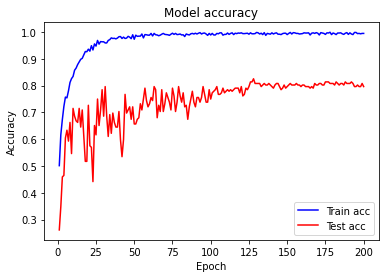

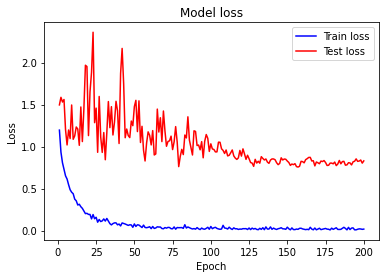

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Train acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
import numpy as np
from keras.preprocessing import image
test_image=tf.keras.utils.load_img(r'C:\Users\ritan\Desktop\Maths for ML\Groundnut FD\Images for checking\img.jpg',target_size=(224,224))
test_image=tf.keras.utils.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
result=result.flatten()
print(result)
print(class_names)
index=result.argmax()
confidence=result[index]*100;
pred_class=class_names[index]
if pred_class!='Groundnut__Healthy':
    print(f'The disease of the given groundnut leaf is {pred_class} predicted with {confidence} % confidence')
else:
    print(f'The groundnut leaf is healthy predicted with {confidence} % confidence')

1/1 [==============================] - 1s 1s/step
[1. 0. 0. 0. 0.]
['Groundnut__Alternaria__Leafspot', 'Groundnut__Early__Late__Leafspot', 'Groundnut__Healthy', 'Groundnut__Rosette', 'Groundnut__Rust']
The disease of the given groundnut leaf is Groundnut__Alternaria__Leafspot predicted with 100.0 % confidence
